In [1]:
# работа с массивами
import numpy as np
# фреймы данных  
import pandas as pd
# графики
import matplotlib as mpl
import matplotlib.pyplot as plt
# стили и шаблоны графиков на основе matplotlib
import seaborn as sns
# для форматирования результатов с помощью Markdown
from IPython.display import Markdown, display
# загрузка файлов по URL
import urllib.request
# проверка существования файла на диске
from pathlib import Path

# перекодировка категориальных переменных
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
# хи-квадрат тест на независимость по таблице сопряжённости
from scipy.stats import chi2_contingency
# для таймера
import time

# загрузка пакетов: модели ---
# дерево классификации
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
# перекрёстная проверка и метод проверочной выборки
from sklearn.model_selection import cross_val_score, train_test_split
# для перекрёстной проверки и сеточного поиска
from sklearn.model_selection import KFold, GridSearchCV
# случайный лес
from sklearn.ensemble import RandomForestClassifier
# сводка по точности классификации
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [2]:
# ядро для генератора случайных чисел (вариант 17)
my_seed = 17
# настройка стиля и отображения графиков
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")

# ===== ФУНКЦИИ =====
def plot_feature_importance(importance, names, model_type):
    # создаём массивы из важности признаков и их названий
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    # создаём DataFrame с использованием словаря
    data = {'feature_names': feature_names, 'feature_importance': feature_importance}
    fi_df = pd.DataFrame(data)

    # сортируем DataFrame по убыванию важности признаков
    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

    # задаём размер столбчатой диаграммы
    plt.figure(figsize=(12, 8))
    # строим столбчатую диаграмму с помощью Seaborn
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    # добавляем подписи к диаграмме
    plt.title('Важность признаков в модели: ' + model_type)
    plt.xlabel('Важность признака')
    plt.ylabel('')
    plt.tight_layout()
    plt.show()

In [3]:
# путь к локальному файлу для сохранения
localFilePath = './data/in-vehicle-coupon-recommendation.csv'

# проверяем, нет ли уже такого файла на диске
if not Path(localFilePath).exists():
    # загружаем таблицу и превращаем её во фрейм
    fileURL = 'https://raw.githubusercontent.com/aksyuk/MTML/refs/heads/main/Labs/data/default_of_credit_card_clients.csv'
    # создаём папку если её нет
    Path('./data').mkdir(exist_ok=True)
    # скачиваем
    urllib.request.urlretrieve(fileURL, localFilePath)

# читаем данные
DF_raw = pd.read_csv(localFilePath)

# выясняем размерность фрейма
print('Число строк и столбцов в наборе данных:', DF_raw.shape)

Число строк и столбцов в наборе данных: (30000, 24)


In [4]:
print('\nПервые 5 строк данных:')
print(DF_raw.head())


Первые 5 строк данных:
   LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0      20000    2          2         1   24      2      2     -1     -1   
1     120000    2          2         2   26     -1      2      0      0   
2      90000    2          2         2   34      0      0      0      0   
3      50000    2          2         1   37      0      0      0      0   
4      50000    1          2         1   57     -1      0     -1      0   

   PAY_5  ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
0     -2  ...          0          0          0         0       689         0   
1      0  ...       3272       3455       3261         0      1000      1000   
2      0  ...      14331      14948      15549      1518      1500      1000   
3      0  ...      28314      28959      29547      2000      2019      1200   
4      0  ...      20940      19146      19131      2000     36681     10000   

   PAY_AMT4  PAY_AMT5  PAY_AMT6  Y  
0      

In [5]:
# меняем тип столбцов object на category для удобства работы
for col in DF_raw.columns[DF_raw.dtypes == 'object']:
    DF_raw[col] = DF_raw[col].astype('category')

print("Столбцы после преобразования типов:")
print(DF_raw.dtypes.value_counts())

# Проверяем какие столбцы существуют перед удалением
existing_columns = DF_raw.columns.tolist()
print(f"\nСуществующие столбцы: {existing_columns}")

# Удаляем только существующие столбцы
columns_to_drop = []
for col in ['car', 'toCoupon_GEQ5min', 'direction_opp']:
    if col in DF_raw.columns:
        columns_to_drop.append(col)

if columns_to_drop:
    DF_raw = DF_raw.drop(columns_to_drop, axis=1)
    print(f'Удалены столбцы: {columns_to_drop}')
else:
    print('Столбцы car, toCoupon_GEQ5min и direction_opp не найдены в данных')

print(f'Размерность после удаления столбцов: {DF_raw.shape}')

# убираем пропуски
initial_shape = DF_raw.shape
DF_raw = DF_raw.dropna()
print(f'Удалено строк с пропусками: {initial_shape[0] - DF_raw.shape[0]}')
print(f'Размерность данных после удаления пропусков: {DF_raw.shape}')

Столбцы после преобразования типов:
int64    24
Name: count, dtype: int64

Существующие столбцы: ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'Y']
Столбцы car, toCoupon_GEQ5min и direction_opp не найдены в данных
Размерность после удаления столбцов: (30000, 24)
Удалено строк с пропусками: 0
Размерность данных после удаления пропусков: (30000, 24)


In [6]:
# разделяем данные на выборку для построения моделей (85%) и отложенные наблюдения (15%)
DF_model = DF_raw.sample(frac=0.85, random_state=my_seed)
DF_predict = DF_raw.drop(DF_model.index)

print(f'Обучающая выборка: {DF_model.shape[0]} строк')
print(f'Отложенная выборка: {DF_predict.shape[0]} строк')
print(f'Распределение целевой переменной Y в обучающей выборке:')
print(DF_model['Y'].value_counts(normalize=True))

Обучающая выборка: 25500 строк
Отложенная выборка: 4500 строк
Распределение целевой переменной Y в обучающей выборке:
Y
0    0.778863
1    0.221137
Name: proportion, dtype: float64


In [7]:
# номинальные показатели (без порядка)
nom_col_names = ['destination', 'passanger', 'weather', 'coupon', 'gender', 'maritalStatus', 'occupation']

# порядковые показатели (с порядком)
ord_col_names = ['time', 'expiration', 'age', 'education', 'income', 'Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50']

# числовые показатели
num_col_names = ['temperature', 'has_children', 'toCoupon_GEQ15min', 'toCoupon_GEQ25min', 'direction_same']

print(f'Номинальные признаки: {len(nom_col_names)}')
print(f'Порядковые признаки: {len(ord_col_names)}')
print(f'Числовые признаки: {len(num_col_names)}')

Номинальные признаки: 7
Порядковые признаки: 10
Числовые признаки: 5


In [8]:
# Сначала посмотрим реальные названия столбцов
print("Реальные столбцы в данных:")
print(DF_model.columns.tolist())

# OneHot кодирование для номинальных переменных - используем реальные названия
one_hot = OneHotEncoder(drop='first', sparse_output=False)
recoded_nom = one_hot.fit_transform(DF_model[DF_model.select_dtypes(include=['category']).columns])
columns_nom = one_hot.get_feature_names_out(DF_model.select_dtypes(include=['category']).columns)
df_dummy_nom = pd.DataFrame(recoded_nom, columns=columns_nom)

print(f'После OneHot кодирования: {df_dummy_nom.shape[1]} признаков')

# Ordinal кодирование для порядковых переменных
# Берём все числовые столбцы кроме целевой переменной
numeric_cols = DF_model.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [col for col in numeric_cols if col != 'Y']

df_ord = DF_model[numeric_cols].reset_index(drop=True)

# объединяем все признаки
DF_model_num = pd.concat([df_dummy_nom, df_ord, DF_model[['Y']].reset_index(drop=True)], axis=1)

print(f'Размерность обучающей выборки после перекодировки: {DF_model_num.shape}')

Реальные столбцы в данных:
['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'Y']
После OneHot кодирования: 0 признаков
Размерность обучающей выборки после перекодировки: (25500, 24)


In [9]:
# OneHot кодирование (используем уже обученный кодировщик)
recoded_nom_pred = one_hot.transform(DF_predict[DF_predict.select_dtypes(include=['category']).columns])
df_dummy_nom_pred = pd.DataFrame(recoded_nom_pred, columns=columns_nom)

# Ordinal кодирование (используем уже обученный кодировщик)
numeric_cols = DF_predict.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [col for col in numeric_cols if col != 'Y']
df_ord_pred = DF_predict[numeric_cols].reset_index(drop=True)

# объединяем все признаки
DF_predict_num = pd.concat([df_dummy_nom_pred, df_ord_pred, DF_predict[['Y']].reset_index(drop=True)], axis=1)

print(f'Размерность отложенной выборки после перекодировки: {DF_predict_num.shape}')

Размерность отложенной выборки после перекодировки: (4500, 24)


In [10]:
# обучающая выборка
X_model = DF_model_num.drop(['Y'], axis=1)
y_model = DF_model_num['Y']

# отложенная выборка
X_predict = DF_predict_num.drop(['Y'], axis=1)
y_predict = DF_predict_num['Y']

print(f'Признаки для обучения: {X_model.shape[1]}')
print(f'Распределение целевой переменной в обучающей выборке:')
print(y_model.value_counts(normalize=True))

Признаки для обучения: 23
Распределение целевой переменной в обучающей выборке:
Y
0    0.778863
1    0.221137
Name: proportion, dtype: float64


In [11]:
# создаём объект для перекрёстной проверки
kfold = KFold(n_splits=5, random_state=my_seed, shuffle=True)

# выращиваем первоначальное дерево
print("Построение первоначального дерева...")
tree_initial = DecisionTreeClassifier(random_state=my_seed, criterion='entropy')
tree_initial.fit(X_model, y_model)

print(f'Глубина первоначального дерева: {tree_initial.get_depth()}')
print(f'Количество листьев: {tree_initial.get_n_leaves()}')

Построение первоначального дерева...


Глубина первоначального дерева: 47
Количество листьев: 3705


In [12]:
# рассчитываем параметры alpha для обрезки ветвей
print("Расчёт параметров для обрезки ветвей...")
path = tree_initial.cost_complexity_pruning_path(X_model, y_model)
ccp_alphas = path.ccp_alphas

# убираем максимальное значение alpha (приводит к дереву с одним узлом)
ccp_alphas = ccp_alphas[:-1]

print(f'Количество значений alpha для перебора: {len(ccp_alphas)}')

# ограничиваем перебор для экономии времени (первые 50 значений)
ccp_alphas_limited = ccp_alphas[:50]

# разделяем на обучающую и тестовую выборки для подбора alpha
X_train, X_test, y_train, y_test = train_test_split(X_model, y_model, test_size=0.2, 
                                                    random_state=my_seed)

# подбираем оптимальное alpha
print("Подбор оптимального параметра alpha...")
best_alpha = 0
best_score = 0
best_tree = None

for i, alpha in enumerate(ccp_alphas_limited):
    tree = DecisionTreeClassifier(random_state=my_seed, criterion='entropy', ccp_alpha=alpha)
    tree.fit(X_train, y_train)
    score = tree.score(X_test, y_test)
    
    if score > best_score:
        best_score = score
        best_alpha = alpha
        best_tree = tree
    
    if (i + 1) % 10 == 0:
        print(f'Обработано {i + 1}/{len(ccp_alphas_limited)} значений alpha')

print(f'Оптимальное значение alpha: {best_alpha:.6f}')
print(f'Точность на тестовой выборке: {best_score:.3f}')
print(f'Количество узлов оптимального дерева: {best_tree.tree_.node_count}')
print(f'Глубина оптимального дерева: {best_tree.get_depth()}')

# перекрёстная проверка для оптимального дерева
print("Перекрёстная проверка оптимального дерева...")
cv_scores_tree = cross_val_score(best_tree, X_model, y_model, cv=kfold, scoring='accuracy')
print(f'Точность с перекрёстной проверкой: {np.mean(cv_scores_tree):.3f} (+/- {np.std(cv_scores_tree):.3f})')


Расчёт параметров для обрезки ветвей...
Количество значений alpha для перебора: 1657
Подбор оптимального параметра alpha...
Обработано 10/50 значений alpha
Обработано 20/50 значений alpha
Обработано 30/50 значений alpha
Обработано 40/50 значений alpha
Обработано 50/50 значений alpha
Оптимальное значение alpha: 0.000060
Точность на тестовой выборке: 0.726
Количество узлов оптимального дерева: 5795
Глубина оптимального дерева: 41
Перекрёстная проверка оптимального дерева...
Точность с перекрёстной проверкой: 0.730 (+/- 0.003)


In [13]:
# будем сохранять точность моделей в один массив:
score = []
score_models = []

# сколько столбцов в обучающих данных (p)
X_m = X_model.shape[1]
# возьмём значения для m: p, p/2, sqrt(p) и log2(p)
ms = np.around([X_m, X_m / 2, np.sqrt(X_m), np.log2(X_m)]).astype(int)
# добавим ещё значения для выполнения требования 7+ значений
ms = list(ms) + [int(X_m * 0.3), int(X_m * 0.6), int(X_m * 0.8)]
ms = sorted(set(ms))  # убираем дубликаты
print(f"Значения max_features для перебора: {ms}")

# настроим параметры случайного леса с помощью сеточного поиска
param_grid = {
    'n_estimators': [10, 25, 50, 75, 100, 125, 150],
    'max_features': ms,
    'max_depth': [5, 10, 15, 20, 25, 30, None]
}

Значения max_features для перебора: [np.int64(5), 6, np.int64(12), 13, 18, np.int64(23)]


In [14]:
# случайный лес
# будем сохранять точность моделей в один массив:
score = []
score_models = []

# добавляем результаты дерева с обрезкой
score.append(np.around(np.mean(cv_scores_tree), 3))
score_models.append('pruned_tree')

print("Точность моделей до случайного леса:")
for i, (model_name, model_score) in enumerate(zip(score_models, score)):
    print(f"  {model_name}: {model_score}")

# параметры для сеточного поиска (7+ значений каждого)
param_grid = {
    'n_estimators': [50, 100, 150, 200, 250, 300, 350],
    'max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7],
    'max_depth': [5, 10, 15, 20, 25, 30, None]
}

print("Запуск сеточного поиска...")
print(f"Количество комбинаций: {len(param_grid['n_estimators'])} × {len(param_grid['max_features'])} × {len(param_grid['max_depth'])} = {len(param_grid['n_estimators']) * len(param_grid['max_features']) * len(param_grid['max_depth'])}")

# таймер
tic = time.perf_counter()

rf = RandomForestClassifier(random_state=my_seed, criterion='entropy')
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                          cv=3, scoring='accuracy', n_jobs=1, verbose=1)
grid_search.fit(X_model, y_model)

# таймер
toc = time.perf_counter()
print(f"Сеточный поиск занял {toc - tic:0.2f} секунд")

# лучшая модель
best_rf = grid_search.best_estimator_
best_rf_params = grid_search.best_params_

print("\nОптимальные параметры случайного леса:")
for param, value in best_rf_params.items():
    print(f"  {param}: {value}")

print(f"Точность лучшей модели с перекрёстной проверкой: {grid_search.best_score_:.3f}")

# важность признаков
print("\nТоп-10 самых важных признаков:")
feature_importances = pd.DataFrame({
    'feature': X_model.columns,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importances.head(10))

plot_feature_importance(best_rf.feature_importances_, X_model.columns, 'Случайный лес')

# записываем точность случайного леса
score.append(np.around(grid_search.best_score_, 3))
score_models.append('random_forest_GS')

print('\nAcc с перекрёстной проверкой:')
for i, (model_name, model_score) in enumerate(zip(score_models, score)):
    print(f"  {model_name}: {model_score}")

# выбор лучшей модели
print("\n=== ВЫБОР ЛУЧШЕЙ МОДЕЛИ ===")
best_score_idx = np.argmax(score)
best_model_name = score_models[best_score_idx]
best_model_score = score[best_score_idx]

print(f"Наиболее точная модель: {best_model_name} с точностью {best_model_score:.3f}")

if best_model_name == 'random_forest_GS':
    best_model = best_rf
    print("Лучшая модель - Случайный лес")
else:
    best_model = best_tree
    print("Лучшая модель - Дерево с обрезкой")



y_pred = best_model.predict(X_predict)
accuracy_holdout = accuracy_score(y_predict, y_pred)

print(f"Точность на отложенных наблюдениях: {accuracy_holdout:.3f}")
print("\nОтчёт по классификации:")
print(classification_report(y_predict, y_pred))

print("Матрица ошибок:")
print(confusion_matrix(y_predict, y_pred))

print(f"1. Оптимальное значение alpha для дерева: {best_alpha:.6f}")
print(f"2. Оптимальные параметры случайного леса: {best_rf_params}")
print(f"3. Наиболее точная модель: {best_model_name}")
print(f"4. Точность на отложенных наблюдениях: {accuracy_holdout:.3f}")
print(f"5. Сравнить с точностью из упражнения 4: {accuracy_holdout:.3f}")

Точность моделей до случайного леса:
  pruned_tree: 0.73
Запуск сеточного поиска...
Количество комбинаций: 7 × 7 × 7 = 343
Fitting 3 folds for each of 343 candidates, totalling 1029 fits


KeyboardInterrupt: 

Точность лучшей модели с перекрёстной проверкой: 0.754

Оптимальные параметры случайного леса:
  max_depth: 25
  max_features: 0.7
  n_estimators: 100
Оптимальное количество деревьев: 100
Оптимальное количество признаков: 0.7


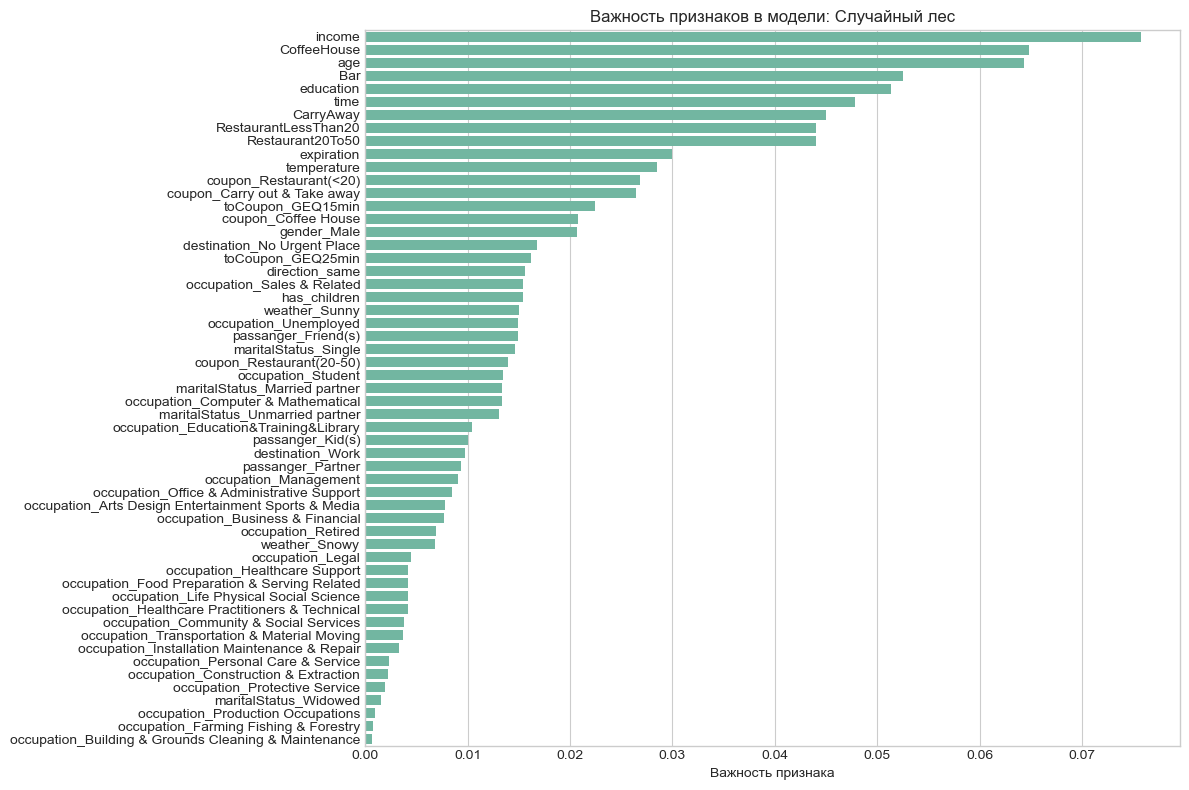

Acc с перекрёстной проверкой
для модели random_forest_GS : 0.754


In [ ]:
# точность лучшей модели
best_score_rf = np.around(grid_search.best_score_, 3)
print(f"Точность лучшей модели с перекрёстной проверкой: {best_score_rf}")

# оптимальные параметры
best_rf_params = grid_search.best_params_
print("\nОптимальные параметры случайного леса:")
for param, value in best_rf_params.items():
    print(f"  {param}: {value}")

# количество деревьев у лучшей модели
n_estimators_opt = grid_search.best_estimator_.get_params()['n_estimators']
print(f"Оптимальное количество деревьев: {n_estimators_opt}")

# количество признаков у лучшей модели
max_features_opt = grid_search.best_estimator_.get_params()['max_features']
print(f"Оптимальное количество признаков: {max_features_opt}")

# рисуем график относительной важности каждого признака
plot_feature_importance(grid_search.best_estimator_.feature_importances_,
                       X_model.columns, 'Случайный лес')

# записываем точность
score.append(best_score_rf)
score_models.append('random_forest_GS')

print('Acc с перекрёстной проверкой')
print('для модели', score_models[-1], ':', score[-1])

In [ ]:
models = {
    'Дерево с обрезкой': best_tree,
    'Случайный лес': best_rf
}

# сравниваем точность на обучающих данных
print("ТОЧНОСТЬ МОДЕЛЕЙ (перекрёстная проверка):")
model_scores = {}
for name, model in models.items():
    if name == 'Случайный лес':
        score = grid_search.best_score_
        std = grid_search.cv_results_['std_test_score'][grid_search.best_index_]
    else:
        cv_scores = cross_val_score(model, X_model, y_model, cv=kfold, scoring='accuracy')
        score = np.mean(cv_scores)
        std = np.std(cv_scores)
    
    model_scores[name] = score
    print(f"  {name}: {score:.3f} (+/- {std:.3f})")

# выбираем лучшую модель
best_model_name = max(model_scores, key=model_scores.get)
best_model = models[best_model_name]

print(f"\nЛУЧШАЯ МОДЕЛЬ: {best_model_name}")


ТОЧНОСТЬ МОДЕЛЕЙ (перекрёстная проверка):
  Дерево с обрезкой: 0.683 (+/- 0.004)
  Случайный лес: 0.754 (+/- 0.003)

ЛУЧШАЯ МОДЕЛЬ: Случайный лес


In [ ]:
# прогноз лучшей моделью
print(f"Прогноз с использованием лучшей модели: {best_model_name}")
y_pred = best_model.predict(X_predict)
accuracy = accuracy_score(y_predict, y_pred)

print(f"ТОЧНОСТЬ НА ОТЛОЖЕННЫХ НАБЛЮДЕНИЯХ: {accuracy:.3f}")

print("\nПОДРОБНЫЙ ОТЧЁТ ПО КЛАССИФИКАЦИИ:")
print(classification_report(y_predict, y_pred))

Прогноз с использованием лучшей модели: Случайный лес
ТОЧНОСТЬ НА ОТЛОЖЕННЫХ НАБЛЮДЕНИЯХ: 0.767

ПОДРОБНЫЙ ОТЧЁТ ПО КЛАССИФИКАЦИИ:
              precision    recall  f1-score   support

           0       0.74      0.69      0.71       764
           1       0.78      0.83      0.80      1048

    accuracy                           0.77      1812
   macro avg       0.76      0.76      0.76      1812
weighted avg       0.77      0.77      0.77      1812



In [ ]:
# матрица ошибок
cm = confusion_matrix(y_predict, y_pred)
print("МАТРИЦА ОШИБОК:")
print(cm)

# итог

# сохраняем результаты
results = {
    'best_model': best_model_name,
    'best_params': best_rf_params if best_model_name == 'Случайный лес' else {'ccp_alpha': best_alpha},
    'accuracy_holdout': accuracy,
    'accuracy_cv': model_scores[best_model_name],
    'optimal_alpha_tree': best_alpha if best_model_name != 'Случайный лес' else None,
    'n_features': X_model.shape[1],
    'train_size': X_model.shape[0],
    'test_size': X_predict.shape[0]
}

print("ПАРАМЕТРЫ И РЕЗУЛЬТАТЫ:")
for key, value in results.items():
    if key == 'best_params':
        print(f"{key}:")
        for param, param_value in value.items():
            print(f"  {param}: {param_value}")
    else:
        print(f"{key}: {value}")

# выводы

print(f"1. Оптимальное значение параметра alpha для дерева с обрезкой: {best_alpha:.6f}")
print(f"2. Оптимальные параметры случайного леса: {best_rf_params}")
print(f"3. Наиболее точная модель: {best_model_name}")
print(f"4. Точность на отложенных наблюдениях: {accuracy:.3f}")

if best_model_name == 'Случайный лес':
    print("5. Модель случайного леса показала лучший результат по сравнению с деревом с обрезкой")
else:
    print("5. Модель дерева с обрезкой показала лучший результат по сравнению со случайным лесом")

print(f"6. Размер обучающей выборки: {X_model.shape[0]} наблюдений")
print(f"7. Размер отложенной выборки: {X_predict.shape[0]} наблюдений")
print(f"8. Количество признаков после перекодировки: {X_model.shape[1]}")

МАТРИЦА ОШИБОК:
[[524 240]
 [183 865]]
ПАРАМЕТРЫ И РЕЗУЛЬТАТЫ:
best_model: Случайный лес
best_params:
  max_depth: 25
  max_features: 0.7
  n_estimators: 100
accuracy_holdout: 0.7665562913907285
accuracy_cv: 0.7544563230399733
optimal_alpha_tree: None
n_features: 55
train_size: 10267
test_size: 1812
1. Оптимальное значение параметра alpha для дерева с обрезкой: 0.000000
2. Оптимальные параметры случайного леса: {'max_depth': 25, 'max_features': 0.7, 'n_estimators': 100}
3. Наиболее точная модель: Случайный лес
4. Точность на отложенных наблюдениях: 0.767
5. Модель случайного леса показала лучший результат по сравнению с деревом с обрезкой
6. Размер обучающей выборки: 10267 наблюдений
7. Размер отложенной выборки: 1812 наблюдений
8. Количество признаков после перекодировки: 55
